In [1]:
# Подключаем необходимые библиотеки
import os                                   # Модуль для работы с операционной системой
    
import torch                                # Основной модуль PyTorch 
import torch.nn as nn                       # Модуль PyTorch для работы с нейронными сетями
import torch.utils.data as Data             # Модуль для работы с Dataset'ами

import torchvision                          # Основной модуль PyTorch для работы с изображениями
import torchvision.transforms as transforms # Модуль для преобразования изображений

In [2]:
torch.manual_seed(1)                        # Настраиваем генератор случайных чисел

In [3]:
# Создаем модель нейронной сети:
class CNN( nn.Module ):
    def __init__( self ):
        super( CNN, self ).__init__()
        self.conv1 = nn.Sequential(                   # Первый слой. На вход подается изображение с 3 каналами (RGB), 
                                                      # размером 32х32 или (3, 32, 32) 
            nn.Conv2d(                                # Функиця свертки.  
                in_channels  = 3                      # Количество входящих каналов - 3, равно количеству каналов 
                                                      # изображения
              , out_channels = 16                     # Количество исходящих каналов - 16
              , kernel_size  = 5                      # Размер ядра свертки - 5
              , stride       = 1                      # Смещение при свертке по горизонтали и вертикали - 1
              , padding      = 2                      # Количество дополнительных столбцов и строк, заполненных нулями,
                                                      # у границ изображения
            )
            , nn.ReLU()                               # Функция активации
            , nn.MaxPool2d( kernel_size = 2 )         # Функция субдискретизации с размером ядра - 2
        )                                             # На выходе - изображение ( 16, 16, 16 )  
        
        self.conv2 = nn.Sequential(                   # Второй слой. На входе изображение ( 16, 16, 16 )
              nn.Conv2d( 16, 32, 5, 1, 2 )            # Функция свертки.
            , nn.ReLU()                               # Функция активации.
            , nn.MaxPool2d( 2 )                       # Функция субдискретизации. 
         )                                            # На выходе - изображение ( 32, 8, 8 )
        
        self.out = nn.Linear( 32 * 8 * 8, 10 )        # Персептрон. Первый аргумент - количество входящих пикселей.
                                                      # Второй - размер полносвязного слоя (равен количеству классов, 
                                                      # на которые поделены изображения).

    def forward( self, x ):                           # Переопределяем метод forward класса nn.Module
        x = self.conv1(x)                             # Применяем первый слой.
        x = self.conv2(x)                             # Применяем второй слой.
        x = x.view( x.size(0), -1 )                   # 'Сплющиваем' до одномерного массива  
        x = self.out(x)                               # Формируем перцептрон
        return x                                      # Возвращаем результат

In [4]:
cnn = CNN()                                           # Создаем объект типа CNN
print(cnn)                                            # Выводим на экран архитектуру сети в текстовом виде

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2048, out_features=10, bias=True)
)


In [5]:
# Скачиваем dataset Cifar10 https://www.cs.toronto.edu/~kriz/cifar.html

train_data = torchvision.datasets.CIFAR10(            
      root      = './cifar10/'                        # Папка, в которую будут скачаны изображения, разметка и т.д.
    , train     = True                                # Если True, данные будут созданы из тренировочного dataset'a
                                                      # False - из тестировочного.
    , transform = torchvision.transforms.ToTensor()   # Функция преобразования исходных данных в PyTorch Tensor.
    , download  = True                                # Если True, то данные будут скачаны из удаленного репозитория, 
                                                      # False - будут использованы локальные данные
)

In [6]:
train_loader = Data.DataLoader(                       # Создаем объект типа Data.DataLoader
      dataset    = train_data                         # Входящий dataset'a - train_data
    , batch_size = 50                                 # Сколько изображений войдут в партию
    , shuffle    = True                               # Нужно ли перемешивать изображения в dataset'e.
)

In [7]:
# Объявляем оптимизатор (в конкретном случае - алгоритм Адама).
# На входе - параметры сети и скорость обучения (learning rate)
optimizer = torch.optim.Adam( cnn.parameters(), lr = 0.001 )  

# Объявляем функцию потерь (в конкретном случае - функция кросс-энтропии)
loss_func = nn.CrossEntropyLoss()

In [10]:
# Обучаем нейронную сеть

MAX_EPOCH = 1                                             # Максимальное количество проходов по dataset'y

running_loss = 0.0
for epoch in range( MAX_EPOCH ):
    for step, ( b_images, b_labels ) in enumerate( train_loader ):    # Для всех изображений b_images и разметок b_labels 
        output = cnn( b_images )                                      # Записываем результат работы сети в output
        loss   = loss_func( output, b_labels )                        # Считаем ошибку между результатом output и заданной 
                                                                      # разметкой b_labels
        optimizer.zero_grad()                                         # Обнуляем градиент
        loss.backward()                                               # Используем метод обратного распространения ошибки
        optimizer.step()                                              # Применяем градиент
        
        running_loss += loss.item()                                   # Получаем ошибку на текущем шаге
        if step % 100 == 99:
            print( '[%d, %5d] loss: %f' % ( epoch, step, running_loss / 100) )  # Выводим среднюю ошибку на экран
            running_loss = 0.0                                                   # Обнуляем ошибку

[0,    99] loss: 1.261427
[0,   199] loss: 1.253513
[0,   299] loss: 1.252218
[0,   399] loss: 1.211163
[0,   499] loss: 1.208244
[0,   599] loss: 1.177628
[0,   699] loss: 1.173253
[0,   799] loss: 1.182259
[0,   899] loss: 1.137382
[0,   999] loss: 1.148102


In [11]:
# Загружаем dataset для тестирования

# Объявляем необходимую для визуализаци функцию трансформации
transform = transforms.Compose( [ 
        transforms.ToTensor()
      , transforms.Normalize( ( 0.5,0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ) 
    ]
)

# Скачиваем данные для тестирования работы нейронной сети по аналогии с train_data
test_data = torchvision.datasets.CIFAR10(
      root = './cifar10/'
    , train     = False
    , download  = True
    , transform = transform
)

BATCH_SIZE = 4

test_loader = torch.utils.data.DataLoader(
      test_data
    , batch_size = BATCH_SIZE
    , shuffle    = True
    , num_workers = 2                      # Сколько процессов использоват для загрзки данных
)

Files already downloaded and verified


In [12]:
# Пишем вспомогательную функцию для визуализаци.

import numpy as np
import matplotlib.pyplot as plt

def imshow( img ):
    img   = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow( np.transpose( npimg, (1, 2, 0) ) )

GroundTruth:  ship bird frog horse


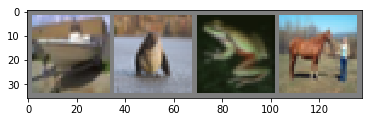

In [13]:
# Объявляем вектор, содержащий названия всех классов изображений
classes   = ( 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' )
# Объявляем итератор по всему тестовому dataset'y
data_iter = iter( test_loader )
# Считываем изображение и разметку.
images, labels = data_iter.next()
# Выводим изображение на экран
imshow( torchvision.utils.make_grid( images ) ) 
# Выводим соответствующие классы
print( 'GroundTruth: ', ' '.join( '%s' % classes[labels[j]] for j in range( BATCH_SIZE ) ))

In [14]:
# Запускаем нейросеть на первых BATCH_SIZE изображениях из тестовой выборки
outputs = cnn( images )
_, predicted = torch.max( outputs, 1 )
print( "Predicted: ", ' '.join( '%s' % classes[predicted[j]] for j in range ( BATCH_SIZE ) ) )

Predicted:  truck dog frog truck


In [15]:
# Напишем функцию оценки точности работы получившейся сети

class_correct = list( 0. for i in range(10) )                     # Выделим нулевой вектор размера 10 (количество классов)
                                                                  # для весов корректно распознанных классов
class_total   = list( 0. for i in range(10) )                     # -- || -- для общих весов классов
with torch.no_grad():                                             # Указываем на то, что градиент не используется
    for data in test_loader:                                      # Для всех изображений тестового dataset'a
        images, labels = data                                     # Получаем текущие изображение и разметку
        outputs = cnn( images )                                   # Применяем нейронную сеть к изображению
        _, predicted = torch.max( outputs, 1 )                    
        c = ( predicted == labels ).squeeze()
        for i in range( BATCH_SIZE ):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

In [16]:
for i in range(10):
    print( 'Accuracy of %s : %d %%' % (classes[i], 100 * class_correct[i] / class_total[i] ) )


Accuracy of airplane : 43 %
Accuracy of automobile : 87 %
Accuracy of bird : 18 %
Accuracy of cat : 49 %
Accuracy of deer : 17 %
Accuracy of dog : 40 %
Accuracy of frog : 74 %
Accuracy of horse : 41 %
Accuracy of ship : 33 %
Accuracy of truck : 58 %
